<a href="https://colab.research.google.com/github/lucasfreire01/student_performance/blob/main/student_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RESUME
I used the XGBosst as an upgrade of Random Florest/ Decision Tree. The goal of the project is to predict the score in which session will have, based on the session passed, the classification of students is split into 3 levels: level 3, level 12, and level 22 in the final the score obtained was 0.66

In [1]:
# Importing library

In [2]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, GroupKFold

In [4]:
# Loading Databases

In [5]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')

In [6]:
test = pd.read_csv('/content/test.csv')

In [7]:
targets = pd.read_csv('/content/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [8]:
targets

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1
...,...,...,...,...
212017,22100215342220508_q18,1,22100215342220508,18
212018,22100215460321130_q18,1,22100215460321130,18
212019,22100217104993650_q18,1,22100217104993650,18
212020,22100219442786200_q18,1,22100219442786200,18


In [9]:
# Creating features to improve algorithm effectiveness by adding a new EVENTS class
# This idea is from: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

In [10]:
CATS = ['event_name','text', 'fqid', 'room_fqid',]
NUMS = ['elapsed_time', 'level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [11]:
def feature_engineer(train):
  dfs = []
  for c in CATS:
    tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
    tmp.name = tmp.name + '_nunique'
    dfs.append(tmp)
  
  for c in NUMS:
    tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
    tmp.name = tmp.name + '_mean'
    dfs.append(tmp)
  for c in NUMS:
    tmp = train.groupby(['session_id','level_group'])[c].agg('std')
    tmp.name = tmp.name + '_std'
    dfs.append(tmp)

  for c in EVENTS: 
    train[c] = (train.event_name == c).astype('int8')

  for c in EVENTS + ['elapsed_time']:
    tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
    tmp.name = tmp.name + '_sum'
    dfs.append(tmp)
  train = train.drop(EVENTS,axis=1)
  
  df = pd.concat(dfs,axis=1)
  df = df.fillna(-1)
  df = df.reset_index()
  df = df.set_index('session_id')
  return df

In [12]:
df = feature_engineer(train)

In [13]:
print(df.shape)
df.head()

(35337, 31)


,level_group,event_name_nunique,text_nunique,fqid_nunique,room_fqid_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,56,30,7,8.579356e+04,1.945455,-1.0,7.701275,-71.413749,...,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,14155937
20090312431273200,13-22,10,168,49,12,1.040601e+06,17.402381,-1.0,-130.347170,-162.004310,...,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,437052322
20090312431273200,5-12,10,124,39,11,3.572052e+05,8.054054,-1.0,14.306062,-57.269322,...,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,105732736
20090312433251036,0-4,11,49,22,6,9.763342e+04,1.870504,0.0,-84.045960,-53.671082,...,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,13571045
20090312433251036,13-22,11,183,73,16,2.498852e+06,17.762529,5.1,-30.762282,-142.861892,...,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3241011333


In [14]:
# The model is training for each one of the 18 questions. With that, we have these insides: level_group = 0-4 for training the model of questions 1-3
#                                                                                           level_group = 5-12 for training the model of questions 4-13
#                                                                                           level_group = 13-22 for training the model of questions 14-18

# This insides was based of test inference I just imported the parameters to train model

In [15]:
FEATURES = [c for c in df.columns if  c != 'level_group']
print('We will try with', len(FEATURES), 'features')
ALL_USERS = df.index.unique()
print ('We will try with', len(ALL_USERS), 'users')

We will try with 30 features
We will try with 11779 users


In [16]:
# starting use GroupKfold with 5 group Kfold
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    for t in range(1,19):
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
               
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################

#########################
### Fold 2
#########################

#########################
### Fold 3
#########################

#########################
### Fold 4
#########################

#########################
### Fold 5
#########################



In [17]:
# I needed to corvert the predicts in a matrix binary with 1s and 0s, the metric use was F1_score that doing a mean between predicts and recall.
# gonna found the ideal limit for p when p > threshold = 1, when p < 1 maximize the F1_score

In [18]:
# Put the true labels with 18 columns
true = oof.copy()
for k in range(18):
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [19]:
# Find the better threshold to convert predicts in 1s and 0s
score = []; thresholds = []
best_score = 0; best_thresholds = 0
for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end=' ')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')      
    score.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_thresholds = threshold

0.40,  0.41,  0.42,  0.43,  0.44,  0.45,  0.46,  0.47,  0.48,  0.49,  0.50,  0.51,  0.52,  0.53,  0.54,  0.55,  0.56,  0.57,  0.58,  0.59,  0.60,  0.61,  0.62,  0.63,  0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.70,  0.71,  0.72,  0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.80,  

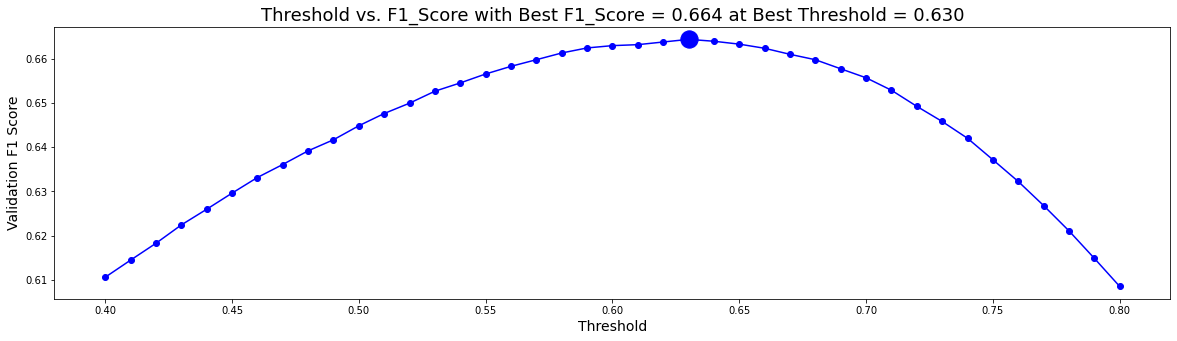

In [20]:
# Plot a graphic threshold vs f1_score
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(thresholds,score,'-o',color='blue')
plt.scatter([best_thresholds], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_thresholds:.3f}',size=18)
plt.show()

In [21]:
# Computing the f1_score for each question
print('When we using optimal threshold...')
for k in range(18):
  m = f1_score(true[k].values, (oof[k].values>best_thresholds).astype('int'), average='macro')
  print(f'Q{k}: F1 = ',m)

# Computing the f1_score overall
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1)) >best_thresholds).astype('int'), average='macro')
print('Overall F1 ==> ', m)

When we using optimal threshold...
Q0: F1 =  0.5897661971056467
Q1: F1 =  0.49448521522681427
Q2: F1 =  0.5048907235463347
Q3: F1 =  0.6090365903780259
Q4: F1 =  0.5706151244065154
Q5: F1 =  0.6119948933857032
Q6: F1 =  0.5904844392962636
Q7: F1 =  0.5185657854128534
Q8: F1 =  0.5902359007772132
Q9: F1 =  0.5436652967324913
Q10: F1 =  0.5664234601092983
Q11: F1 =  0.5040251383974664
Q12: F1 =  0.4778655324931462
Q13: F1 =  0.6022318019760011
Q14: F1 =  0.5481533925717125
Q15: F1 =  0.5055695156451127
Q16: F1 =  0.534166700052737
Q17: F1 =  0.4977980888091081
Overall F1 ==>  0.6643339332383458


In [22]:
df = pd.read_csv('/content/sample_submission.csv')
print(df.shape)
df.head()

(54, 3)


,session_id,correct,session_level
0,20090109393214576_q1,0,20090109393214576_0-4
1,20090312143683264_q1,0,20090312143683264_0-4
2,20090312331414616_q1,0,20090312331414616_0-4
3,20090109393214576_q2,0,20090109393214576_0-4
4,20090312143683264_q2,0,20090312143683264_0-4


In [23]:
print(df.correct.mean())

0.0
